In [ ]:
from collections import Counter
from collections import defaultdict
import itertools
import sys
import time
import json
import configparser
from TwitterAPI import TwitterAPI
import networkx as nx
from networkx.algorithms import community as nxcommunity
import community
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [15]:
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('./../twitter.cfg')
print('Established Twitter connection.')

Established Twitter connection.


In [16]:
twitter

In [ ]:
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200 | request.status_code == 404:
            return request
        else:
            print('Got error %s \n with status code %s\nsleeping for 15 minutes.' % (request.text, request.status_code))
            sys.stderr.flush()
            time.sleep(61 * 15)

In [ ]:
def robust_request_iterate(twitter, resource, params, max_pages=5):
    """ Function for managing pagination of results
    It will sequentially obtain all the pages using the cursor provided by Twittter.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_pages .. The maximum number of pages to ask for.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    ### TODO:
    cursor = -1
    # Add cursor parameter to params:
    params['cursor'] = cursor
    print(params)
    results = []
    while True:
        response = robust_request(twitter, resource, params)
        results.extend(response)
        print(response)
        next_cursor = response.json()['next_cursor']
        print(next_cursor)
        params['cursor'] = next_cursor
        if (next_cursor == 0):
            break
    return results

In [ ]:
def read_screen_names(filename):
    """
    Read a text file containing Twitter screen_names, one per line.

    Params:
        filename....Name of the file to read.
    Returns:
        A list of strings, one per screen_name, in the order they are listed
        in the file.

    Here's a doctest to confirm your implementation is correct.
    >>> read_screen_names('candidates.txt')
    ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
    """
    file = open(filename)
    r = sorted([l.strip() for l in file])
    file.close()
    return r

initial_screen_names = read_screen_names('../data/collect/ethereum-accounts.txt')
print('Read screen names: %s' % initial_screen_names)
# 0 - Read users from file created by collect python script and initial screen_names.
users = pickle.load(open('../data/collect/users.pkl', 'rb'))
print(len(users)) # Check len of users, must be 17 users in the list

In [ ]:
def count_friends_and_followers(users):
    """ Count how often each user is followed or follows the defined users.
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter

    In this example, friend '2' is followed by three different users.
    >>> c = count_friends([{'friends': [1,2]}, {'friends': [2,3]}, {'friends': [2,3]}])
    >>> c.most_common()
    [(2, 3), (3, 2), (1, 1)]
    """
    result = Counter()
    for u in users:
        result.update(u['friends'])
        result.update(u['followers'])
    return result

friend_and_followers_counts = count_friends_and_followers(users)
print(len(friend_and_followers_counts))
a = [user for user in friend_and_followers_counts.items() if user[1] > 2]
print(len(a))
friend_and_followers_counts.get(users[1]['id'])

In [ ]:
def create_graph(users, friend_and_followers_counts, initial_screen_names, min_value=2):
    """ 
    Create a networkx undirected Graph, adding each candidate, friend and follower
    as a node.  Note: while all candidates and  10 top most common ids should be added to the graph,
    only friends and followers are added to the graph if they are followed by more than min_value
    candidates. (This is to reduce clutter.)

    Each candidate in the Graph will be represented by their screen_name. Each of the most_common
    ids will be represented by their user id, as well as each friend and follower will be represented by their user id.

    Args:
      users..........................The list of user dicts.
      friend__and_followers_counts...The Counter dict mapping each friend and follower to the number of candidates that follow them.
      initial_screen_names...........The list of the ethreum accounts we started the project with.
      min_value......................The threshold for adding a user to the graph or not. If the number of people who follow or are friends for a user is less than this number, then do nt added to the graph.
    Returns:
      A networkx Graph
      A list of users that should have labels.
    """
    # Create a graph
    graph = nx.Graph()
    # Set the names for the initial_screen_names and the most common ids.
    nodes_with_labels = []
    for u in users:
        # Create nodes
        if u['screen_name'] in initial_screen_names:
            # Really important to convert the names as strings
            name_in_graph = str(u['screen_name'])
            nodes_with_labels.append(name_in_graph)
            if name_in_graph not in graph:
                graph.add_node(name_in_graph)
        else:
            name_in_graph = str(u['id'])
            # Only add if count is greater than min_value
            if friend_and_followers_counts.get(u['id'])>min_value:
                nodes_with_labels.append(name_in_graph)
                if name_in_graph not in graph:
                    graph.add_node(name_in_graph)
        # Create edges
        friends = u['friends']
        for f in friends:
            if (friend_and_followers_counts.get(f)>min_value):
                if not graph.has_edge(name_in_graph, str(f)):
                    graph.add_edge(name_in_graph, str(f))
        followers = u['followers']
        for follower in followers:
            if (friend_and_followers_counts.get(follower)>min_value):
                if not graph.has_edge(name_in_graph, str(follower)):
                    graph.add_edge(name_in_graph, str(follower))
    
    values_persist = tuple([graph, nodes_with_labels])
    #pickle.dump(values_persist, open(filename, 'wb'))
    return graph, nodes_with_labels

min_value = 2
graph, nodes_with_labels = create_graph(users, friend_and_followers_counts, initial_screen_names, min_value)
print('graph has %s nodes and %s edges with min_value = %d' % (len(graph.nodes()), len(graph.edges()), min_value))

In [ ]:
%%time
def draw_network(graph, initial_screen_name, nodes_labeled, filename):
    """
    Draw the network to a file. Only label the candidate nodes and top 100 most common ids; the friend and followers
    nodes should have no labels (to reduce clutter).
    
    Args:
      graph..........................The networkx graph to draw.
      initial_screen_names...........The list of the ethreum accounts we started the project with.
      nodes_with_labels..............The list of nodes that should have a label in the drawing.
      filename.......................The name of the file to store the image.
    Returns:
      Nothing. (Perists the image into a file)
    
    """    
    # Form list of users screen_names and ids
    nodes = list(graph.nodes())
    colors = ['b'] * len(nodes)
    sizes = [1000] * len(nodes)
    # Compute a dict for the labels
    labels = {}    
    for node in graph.nodes():
        if node in nodes_labeled:
            #set the node name as the key and the label as its value 
            labels[node] = node
            idx = nodes.index(node)
            if node in initial_screen_name:
                colors[idx] = 'r'
                sizes[idx] = 5000
            else:
                colors[idx] = 'g'
                sizes[idx] = 2500
    fig = plt.figure(figsize=(50,50))
    spring_pos = nx.spring_layout(graph)
    plt.axis('off')
    nx.draw_networkx(graph, pos=spring_pos, nodelist=nodes, labels=labels,
                     width=.5, node_color=colors,
                     node_size=sizes, alpha=.5, font_size=40, font_weight='bold')
    #fig.savefig(filename, dpi=fig.dpi)

filename = '../images/cluster/ethereum-network-10-gt'+str(min_value)+'.png'
draw_network(graph, initial_screen_names, nodes_with_labels, filename)
print(filename)    

In [ ]:
def draw_network_communities(graph, node2cluster_dict, initial_screen_names, nodes_labeled, filename):
    """
    Draw the communities of a network to a file. Only label the candidate nodes and top 100 most common ids; the friend and followers
    nodes should have no labels (to reduce clutter).

    Each community will have a different color
    
    Args:
      graph..........................The networkx graph to draw.
      node2cluusterdict..............A dict from node to number of cluster ot which it belongs.
      initial_screen_names...........The list of the ethreum accounts we started the project with.
      nodes_labeled..................The list of nodes that should have a label in the drawing.
      filename.......................The name of the file to store the image.
    Returns:
      Nothing. (Perists the image into a file)
    """
    spring_pos = nx.spring_layout(graph)
    nodes = list(graph.nodes())
    sizes = [1000] * len(nodes)
    labels = {}
    for node in graph.nodes():
        if node in nodes_labeled:
            labels[node] = node
            idx = nodes.index(node)
            if node in initial_screen_names:
                sizes[idx] = 7000
            else:
                sizes[idx] = 2500
    community_values = [node2cluster_dict.get(node) for node in graph.nodes()]
    fig = plt.figure(figsize=(60,60))
    plt.axis("off")
    nx.draw_networkx(graph, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = community_values, node_size = sizes, labels=labels, font_color='gold', font_size=40, font_weight='bold')
    #fig.savefig(filename, dpi=fig.dpi)

In [12]:
def print_comm_summary(node2cluster_dict, nodes_labeled):
    """
    Print a summary of the clustering. Print all the different clusters and the members of the clusters that
    are part of the main nodes.

    Params:
        node2cluuster_dict....A dict that matches each node to the cluster they belong to.
        nodes_labeled.........The list of nodes that contains the main clusters.
    Returns:
        Nothing. (Only prints)

    """
    print("Partition of main nodes obtained by the Louvain Algorithm:")
    num_part = max(node2cluster_dict.values()) + 1
    print("Total number of partitions %d" % num_part)
    for comm_i in range(num_part):
        comm = [node for node, value in node2cluster_dict.items() if value == comm_i and node in nodes_with_labels]
        print("Community %d formed by %s" % (comm_i,comm))

In [13]:
def comm_detect_girvan_newman(graph, nodes_labeled, filename, k=3):
    """
    Cluster the graph in a number of nodes specified by the k paramater, using the girvan_newman
    algorithm from networkx.

    This function will print the progressive clustering of the different nodes. It will only show
    the clustering for the main nodes (the initial twitter users and the top ids picked at the beginnig),
    unless specified different by the user with the all_nodes parameter.
    
    Args:
      graph...............The networkx graph.
      nodes_labeled.......The list of nodes that should have a label in the drawing.
      filename............The name of the file to store the clustering of nodes.
      k...................The number of clusters we want to obtain.
    Returns:
      The result of the Girvan Newman clustering
      A list of dicts with each level corresponding to the partition level.
      
      (Perists the clustering of nodes into into a file and prints the clustering of the main nodes.)
    """
    comp = nxcommunity.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= k, comp)
    result = []
    for communities in limited:
        level_dict = defaultdict(int)
        level_cluster = []
        comm_i = 0
        for cluster in communities:
            for item in cluster:
                level_dict[str(item)] = comm_i
            comm_i += 1
            # if all_nodes:
            #     a = [item for item in cluster]
            # else:
            #     a = [item for item in cluster if item in nodes_labeled]
            #level_cluster.append(a)
        #print(level_cluster)
        #result.append(level_cluster)
        result.append(level_dict)
    #pickle.dump(result, open(filename, 'wb'))
    return result

In [ ]:
num_clusters = 3
print('\n Girvan Newman Algorithm Clustering:')
filename = '../data/cluster/community-detection-girvan-newman-'+str(num_clusters)+'-clusters.pkl'
result_gn_list_dict = comm_detect_girvan_newman(graph, nodes_with_labels, filename, k=num_clusters)
for i in range(len(result_gn_list_dict)):
    filename = '../images/cluster/community_detection_girvan-newman-'+str(i+1)+'-clusters.png'
    draw_network_communities(graph, result_gn_list_dict[i], initial_screen_names, nodes_with_labels, filename)
    print_comm_summary(result_gn_list_dict[i], nodes_with_labels)


 Girvan Newman Algorithm Clustering:


In [13]:
def comm_detect_community(graph, filename):
    """
    Community detection algorithm that uses Louvian method.

    Args:
      graph.................The networkx graph from where to find clusters.
      filename..............The name of the file to store the partitioned graph image.
    Returns:
      A dict from nodes to cluster value.
    """
    partition = community.best_partition(graph, random_state=1234)
    #pickle.dump(partition, open(filename, 'wb'))
    return partition

Louvain Algorithm Clustering:
Partition of main nodes obtained by the Louvain Algorithm:
Total number of partitions 3
Community 0 formed by ['ConsenSysAcad', '3879800793', '913131503667859456', 'gavofyork', 'trufflesuite']
Community 1 formed by ['1102918561339711489', '166021378', '2493743604', '965720461274267648', '1075046092612530177', '1118943462223536128', '1119491594137350144']
Community 2 formed by ['VitalikButerin', '1119509750322999296', 'binance', 'coinbase', 'ethereum']


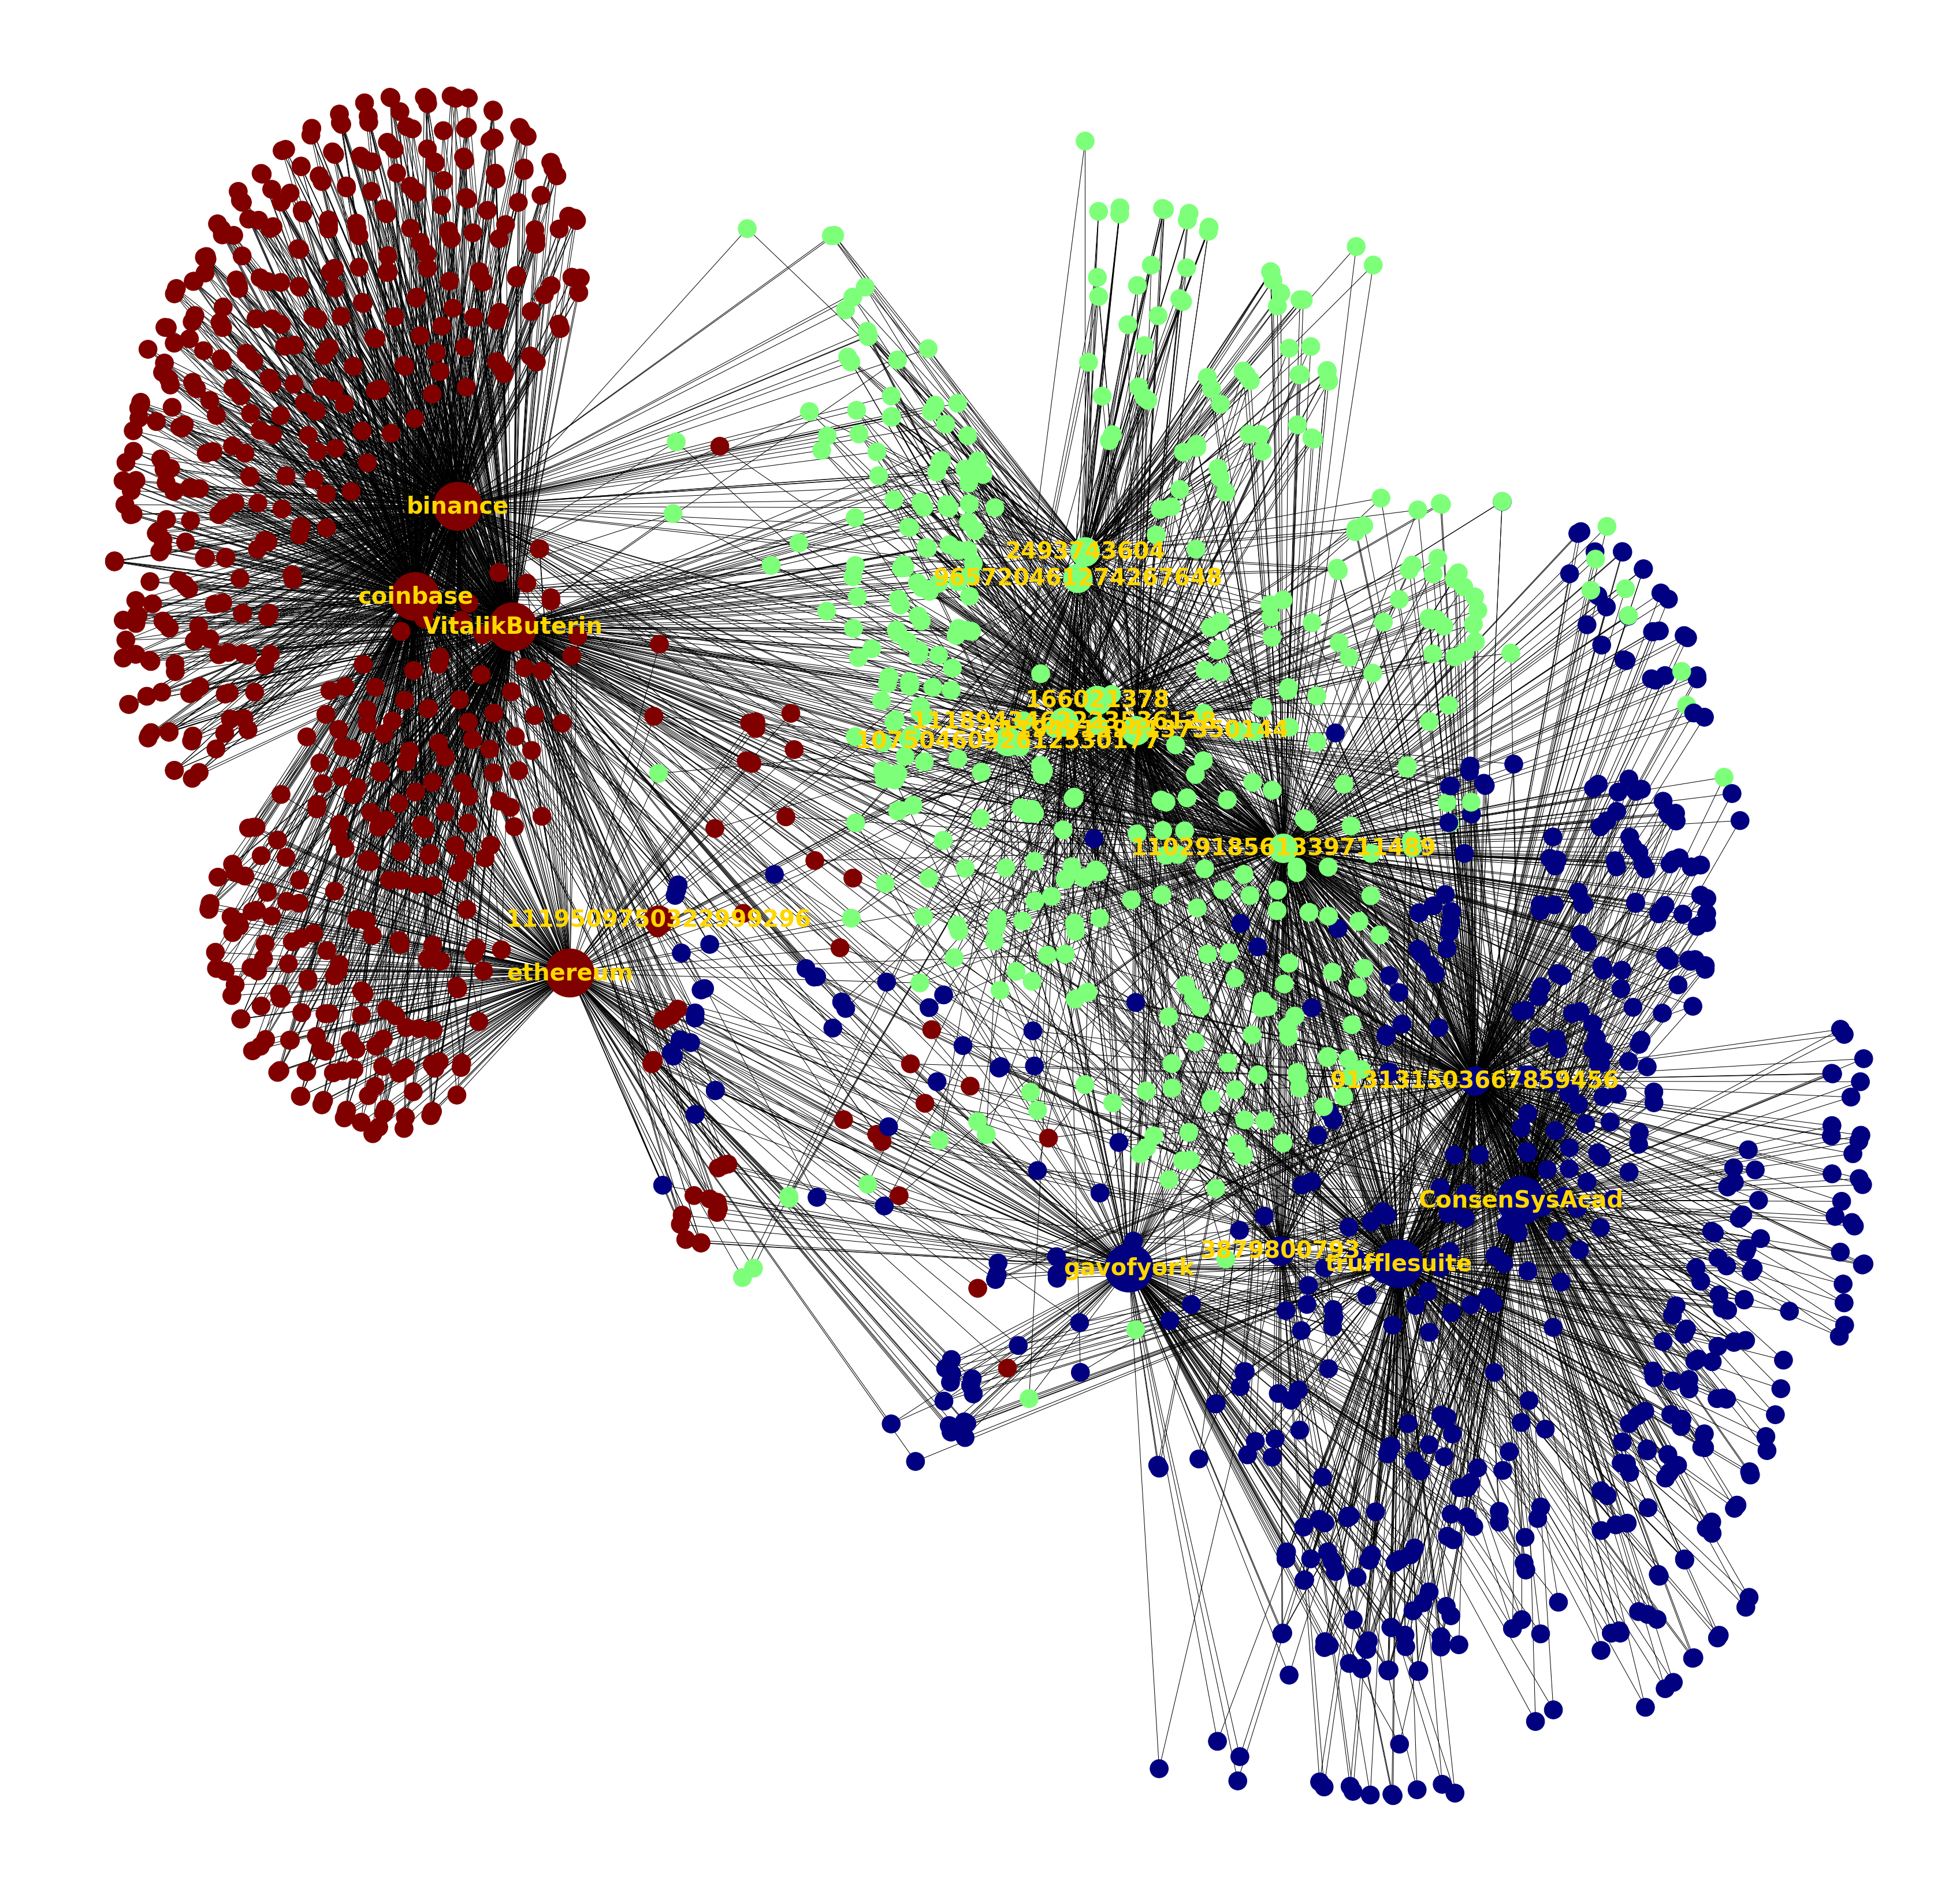

In [16]:
# 4.2 - Community detection using Louvain Algorithm.
print('Louvain Algorithm Clustering:')
filename = '../data/cluster/community_detection_louvian.pkl'
comm_community_dict = comm_detect_community(graph, filename)
filename = '../images/cluster/community_detection_louvian.png'
draw_network_communities(graph, comm_community_dict, initial_screen_names, nodes_with_labels, filename)
print_comm_summary(comm_community_dict, nodes_with_labels)

In [ ]:
def comm_detect_greedy_modularity_community(graph, filename):
    c = list(nxcommunity.greedy_modularity_communities(graph))
    comm_number=0
    node2comm_dict = defaultdict(int)
    for comm in c:
        for node in comm:
            node2comm_dict[str(node)] = comm_number
        comm_number += 1
    #pickle.dump(node2comm_dict, open(filename, 'wb'))
    return node2comm_dict

In [ ]:
# 4.3 - Community detection using Greedy Modularity.
print('\nGreedy Modularity Clustering:')
filename = '../data/cluster/community-detection-greedy-modularity.pkl'
comm_community_dict = comm_detect_greedy_modularity_community(graph, filename)
filename = '../images/cluster/community-detection-greedy-modularity.png'
draw_network_communities(graph, comm_community_dict, initial_screen_names, nodes_with_labels, filename)
print_comm_summary(comm_community_dict, nodes_with_labels)

In [ ]:
list_di = []
for x in range(3):
    di = defaultdict(int)
    for i in range(5):
        di[str(i)] = str(x)+str(i)
    list_di.append(di)